# CNN - Object Detection - Part - 3

#### • DOMAIN: 
> Face recognition
#### • CONTEXT: 
> Company X intends to build a face identification model to recognise human faces.
#### • DATA DESCRIPTION: 
> The dataset comprises of images and its mask where there is a human face.
#### • PROJECT OBJECTIVE: 
> Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken
from 'Pinterest' and aligned using dlib library. Some data samples:
#### • TASK: 
> In this problem, we use a pre-trained model trained on Face recognition to recognise similar faces. Here, we are particularly interested in recognising whether two given faces are of the same person or not as shown in the example below.

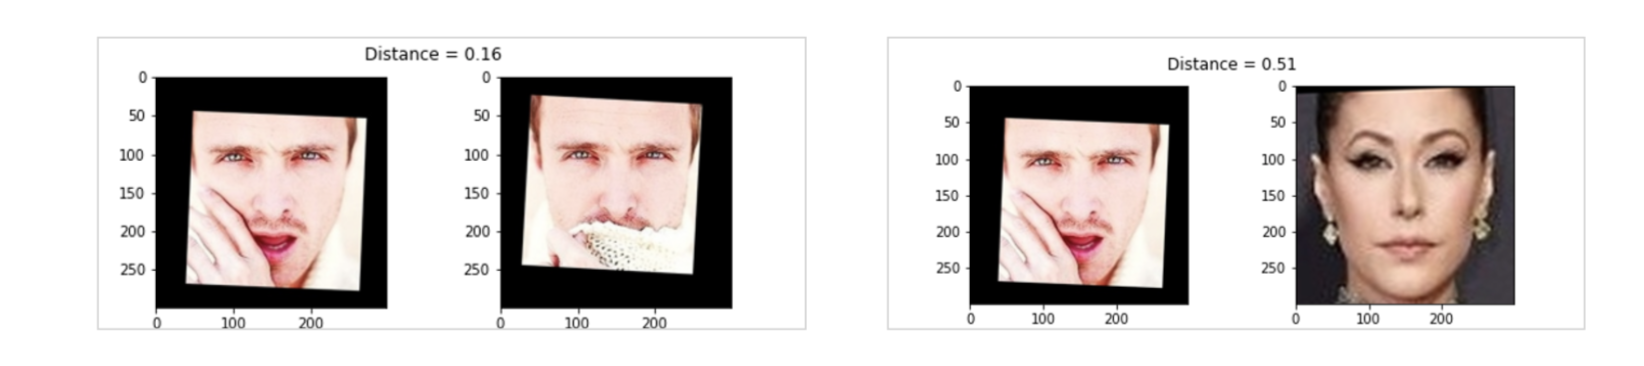



# (1)  Import Python Libraries and Set Path variables

##(1.1) Import Python libraries

In [1]:
import tensorflow as tf

print("You are using TensorFlow version", tf.__version__)
if len(tf.config.list_physical_devices('GPU')) > 0:
  gpu_device = tf.test.gpu_device_name()
  print(f"You have a GPU enabled. GPU ID : {gpu_device}")
else:
  print("Enable a GPU before running this notebook.")


from tensorflow.keras.layers import Input, Dropout, Concatenate, UpSampling2D, Reshape, ZeroPadding2D, MaxPooling2D, Convolution2D, Flatten,  Activation
from tensorflow.keras.models import Model, Sequential


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from tqdm.notebook import trange, tqdm
import seaborn as sns
import random

import cv2
print(f"OpenCV Version is {cv2.__version__}")
from google.colab.patches import cv2_imshow
from IPython.display import Image, display, Markdown, clear_output
from zipfile import ZipFile


import warnings
warnings.filterwarnings("ignore")


You are using TensorFlow version 2.4.1
You have a GPU enabled. GPU ID : /device:GPU:0
OpenCV Version is 4.1.2


## (1.2) Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


##(1.3) Set project path and image file location

In [3]:
project_path = '/content/drive/MyDrive/Colab Notebooks/Project_Object_Detection/OD_Part_3'
zip_file = 'Part 3 - Aligned Face Dataset from Pinterest.zip'

#### Unzip the .zip file containing images and set the base path to the unzip location

In [4]:
images_zip_path = os.path.join(project_path, zip_file)

with ZipFile(images_zip_path, 'r') as z:
  z.extractall()

In [5]:
#### set the base path to the unzip location
unzip_loc = '/content/pins/PINS'


# (2) Read images and create metadata

## (2.1) Function to read images gives the file location.
#### The function also takes additional arguments such as:
>1. **Resizing shape** -> Tuple(A,B)
>2. **Color Conversion flag** -> Boolean (True/False)
>3. Scaling -> Boolean (True/False)

#### Original Image

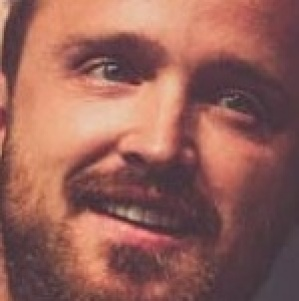

#### Resized and Converted Image

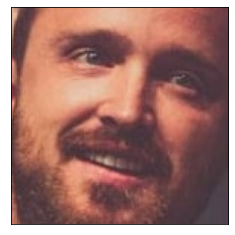

In [6]:
def read_image(img_file,resize=None,cvt_flag=False,scale=False):
  img = cv2.imread(img_file)
  if cvt_flag:
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  if resize != None:
    img = cv2.resize(img,resize)
  if scale:
    img = (img / 255.).astype(np.float32)
    
  return img

### Test the function
display(Markdown("#### Original Image"))
cv2_imshow(read_image(os.path.join(unzip_loc,'pins_Aaron Paul/Aaron Paul0_262.jpg')))
display(Markdown("#### Resized and Converted Image"))
plt.imshow(read_image(os.path.join(unzip_loc,'pins_Aaron Paul/Aaron Paul0_262.jpg'),resize=(224,224),cvt_flag=True,scale=True ));
plt.xticks([])
plt.yticks([])
plt.show();


## (2.2) Create metadata from the image files.
##### The meta data will hold the following details in a dataframe:
> 1. **Filename :** The relative path to the image file from the base path.
> 2. **Celebrity :** Name of the celebrity.
> 3. **Height :** Height of the image in pixels
> 4. **Width :**Width of the image in pixels
> 5. **Num_Channels :** Number of channels
> 6. File Type : The type of image format ( jpg, jpeg etc..)

  Note: The metadata is held in a dataframe for the ease of operation. 

In [7]:
%%time

meta_data_df = pd.DataFrame(columns=['Filename','Celebrity','Height','Width','Num_Channels','File_Type'])
for dirs in tqdm(os.listdir(unzip_loc)):
  for files in os.listdir((os.path.join(unzip_loc,dirs))):
    file_name = os.path.join(dirs,files)
    celebrity = dirs.split("_")[1]
    file_type = files.split('.')[1]
    temp_img = read_image(os.path.join(unzip_loc,file_name))
    if len(temp_img.shape) < 3:
      height, width  = temp_img.shape
    else:
      height, width , num_channels = temp_img.shape
    meta_data_df = meta_data_df.append({'Filename':file_name,
                                        'Celebrity':celebrity,
                                        'Height':height,
                                        'Width':width,
                                        'Num_Channels':num_channels,
                                        'File_Type':file_type},
                                      ignore_index=True)




CPU times: user 1min 11s, sys: 1.25 s, total: 1min 13s
Wall time: 1min 12s


In [8]:
meta_data_df.head()

,Filename,Celebrity,Height,Width,Num_Channels,File_Type
0,pins_Chris Pratt/Chris Pratt9.jpg,Chris Pratt,299,299,3,jpg
1,pins_Chris Pratt/Chris Pratt45.jpg,Chris Pratt,299,299,3,jpg
2,pins_Chris Pratt/Chris Pratt114.jpg,Chris Pratt,299,299,3,jpg
3,pins_Chris Pratt/Chris Pratt4.jpg,Chris Pratt,299,299,3,jpg
4,pins_Chris Pratt/Chris Pratt11.jpg,Chris Pratt,299,299,3,jpg


In [9]:
display(Markdown(f"#### There are {len(meta_data_df)} images from {meta_data_df['Celebrity'].nunique()} celebrities in the image set"))

#### There are 10770 images from 100 celebrities in the image set

In [10]:
dups = len(meta_data_df[meta_data_df['Filename'].duplicated()])
display(Markdown(f"####There are {dups} duplicate files within the image data"))


####There are 0 duplicate files within the image data

In [11]:
meta_data_df.isna().sum().to_frame(name='Na')

,Na
Filename,0
Celebrity,0
Height,0
Width,0
Num_Channels,0
File_Type,0


#### Observation:
> 1. There are  `100` celebrity face iamges in the image set.
> 2. There are `10770` images in total.
> 3. No duplicate files found.
> 4. There are no `Null` or `NaN` values in the metadata dataframe.

## (2.3) Exploratory Data Analysis

### (2.3.1) Distribution of images per celebrity

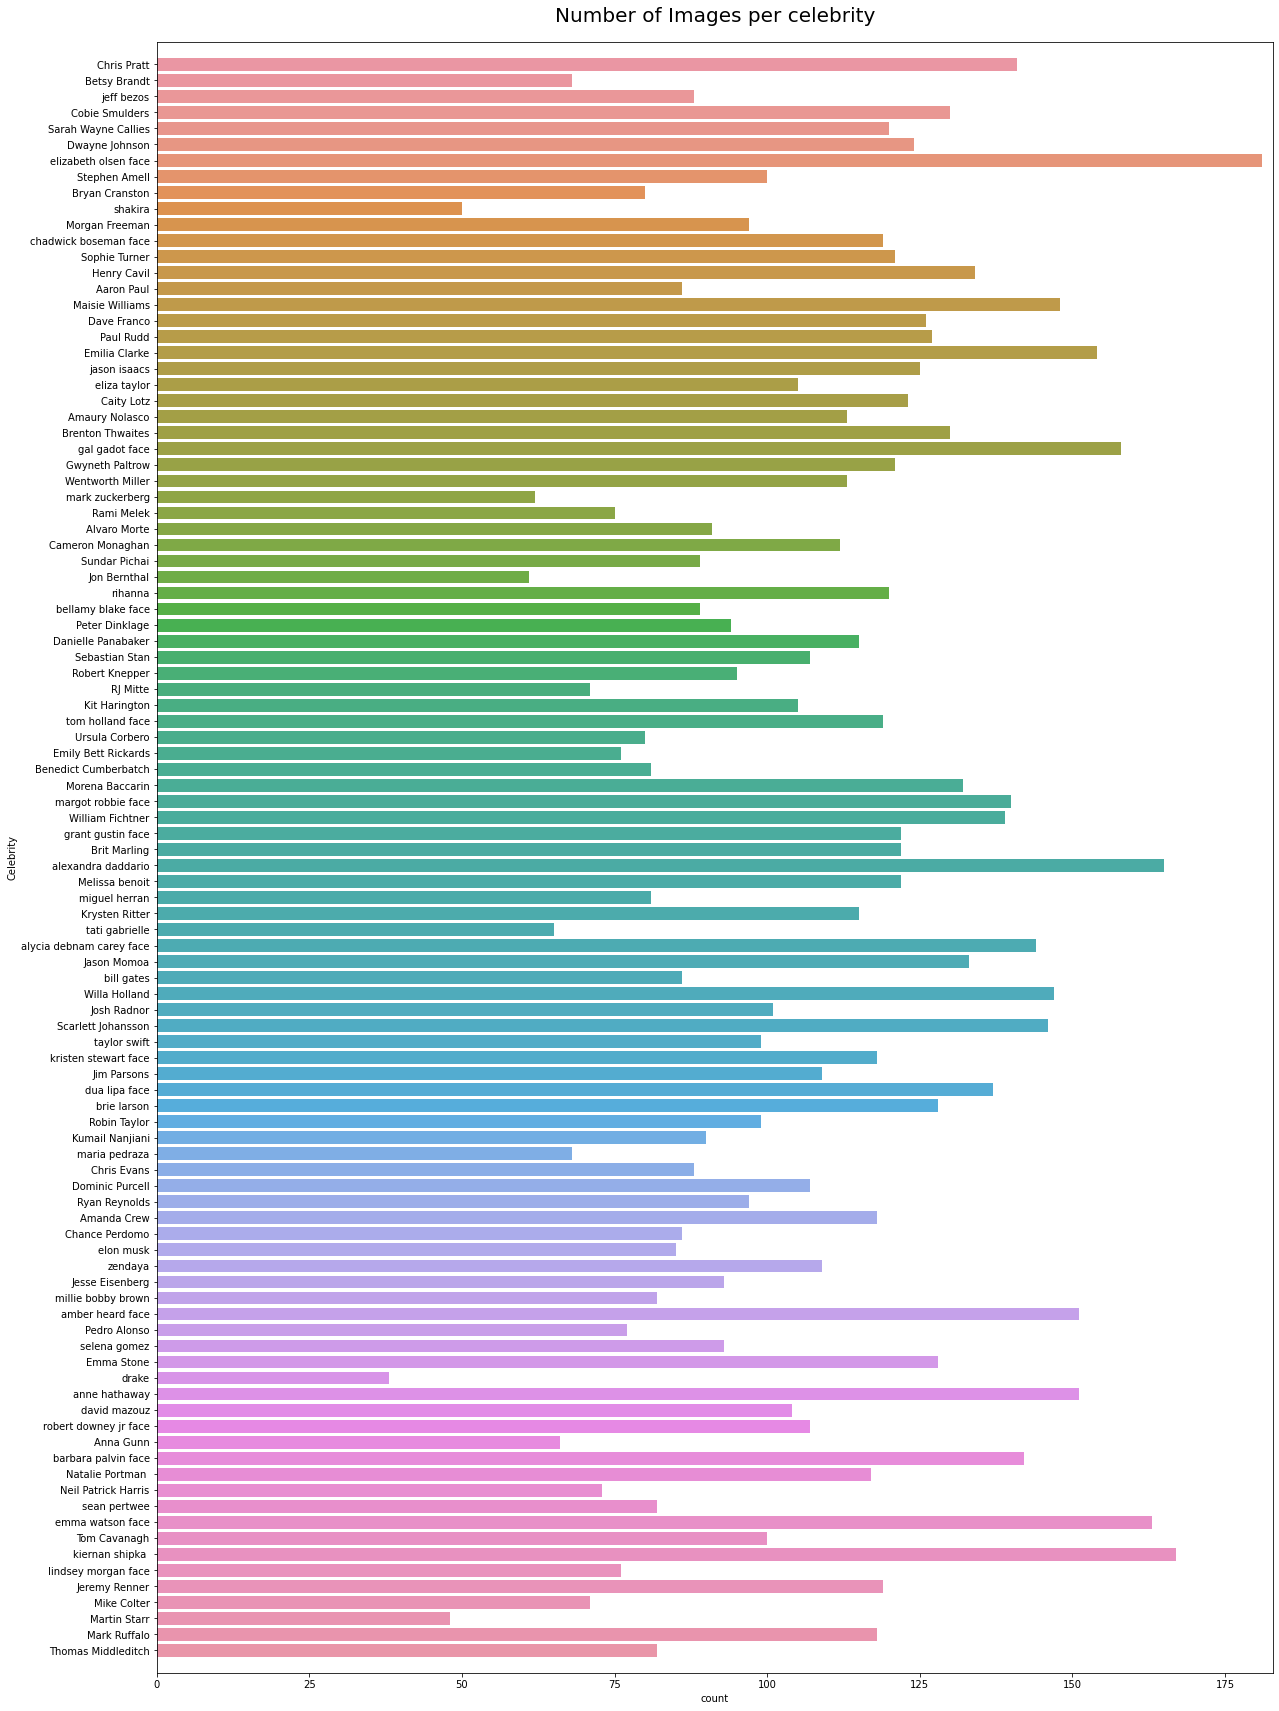

In [12]:
fig,ax = plt.subplots(figsize=(20,30))
sns.countplot(y=meta_data_df['Celebrity'],orient='h')
plt.title("Number of Images per celebrity",pad=20,fontsize=20)
plt.margins(0.01)
plt.show();

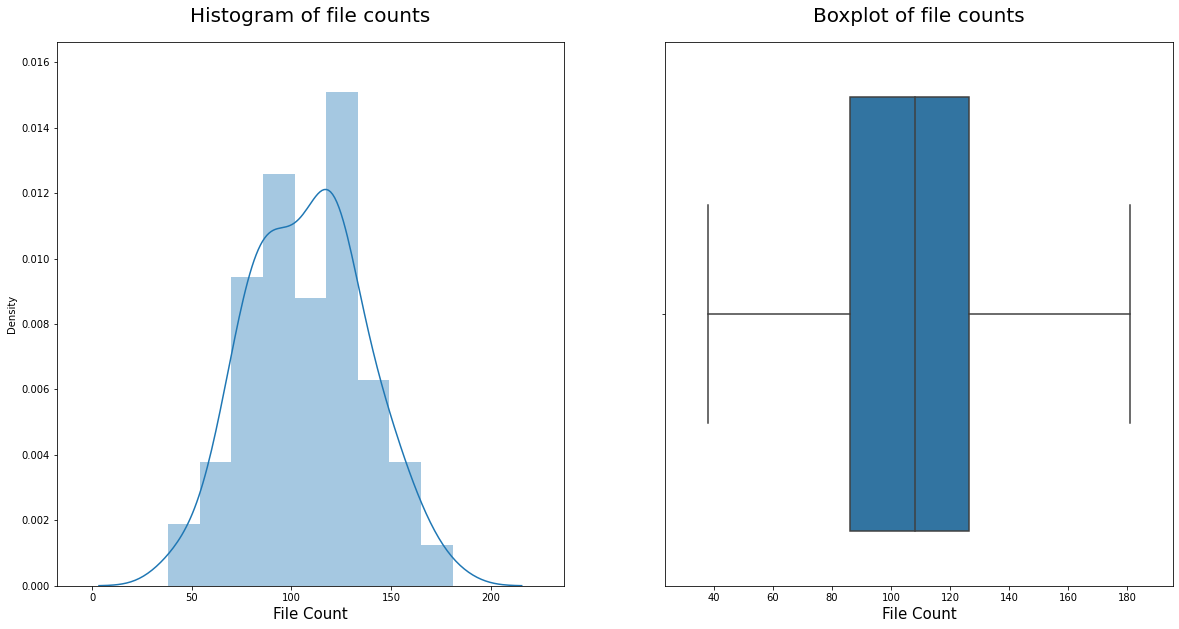

In [13]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
sns.distplot(meta_data_df.groupby('Celebrity')['Filename'].count(),ax=ax[0])
ax[0].set_title("Histogram of file counts",fontsize=20,pad=20)
ax[0].set_xlabel('File Count',fontsize=15)
ax[0].margins(0.1)
sns.boxplot(meta_data_df.groupby('Celebrity')['Filename'].count(),ax=ax[1])
ax[1].set_title("Boxplot of file counts",fontsize=20,pad=20)
ax[1].set_xlabel('File Count',fontsize=15)
ax[1].margins(0.1)
plt.show();

#### Observations:
> 1. The number of images are normally distrubed across all celebrities at an average of 107 images per celebrity.

### (2.3.2) Distribution of other metadata fields

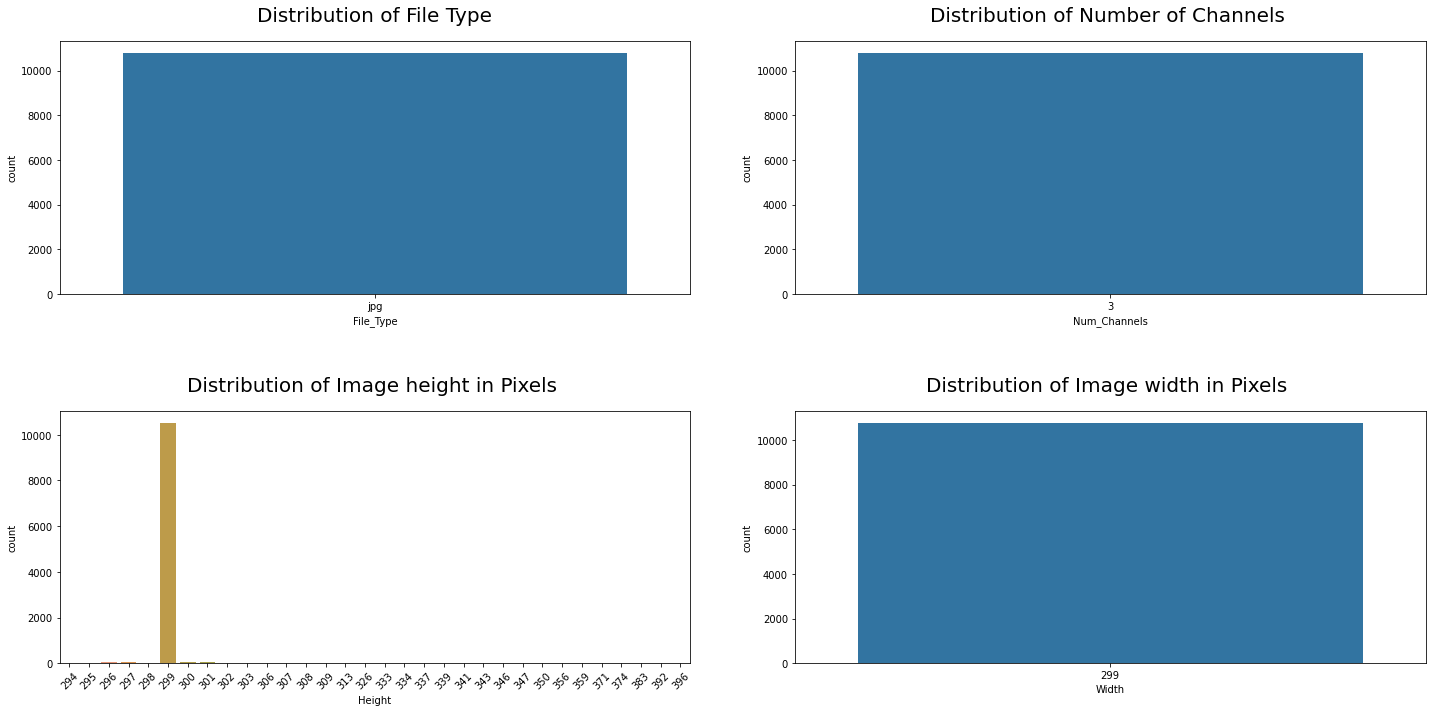

In [14]:
fig,ax = plt.subplots(2,2,figsize=(20,10))

sns.countplot(x=meta_data_df['File_Type'],ax=ax[0][0]);
ax[0][0].set_title("Distribution of File Type",fontsize=20,pad=20)

sns.countplot(x=meta_data_df['Num_Channels'],ax=ax[0][1]);
ax[0][1].set_title("Distribution of Number of Channels ",fontsize=20,pad=20)

ht = sns.countplot(x=meta_data_df['Height'],ax=ax[1][0]);
ax[1][0].set_xticklabels(ht.get_xticklabels(),rotation=45)
ax[1][0].set_title("Distribution of Image height in Pixels ",fontsize=20,pad=20)

sns.countplot(x=meta_data_df['Width'],ax=ax[1][1]);
ax[1][1].set_title("Distribution of Image width in Pixels ",fontsize=20,pad=20)

fig.tight_layout(h_pad=5, w_pad=5)
plt.show();

In [15]:
display(Markdown(f"#### There are {len(meta_data_df[meta_data_df['Height'] != 299])} images with image height `!= 299 pixels`"))

#### There are 244 images with image height `!= 299 pixels`

#### Observation:
> 1. **File Type:** The only filetype we have in the image set is `.jpg`.
> 2. **Number of Channels:** We only have RGB images in the dataset i.e with 3 channels.
> 3. **Height :** More than 10K images have image height of 299 pixels. However there are also images with slightly different image size i.e from 294 - 396 pixels. All will be normalised once we resize these images.
> 4. **Width :** All images have a width of 299 pixels.

##(2.4) Display 5 random images from the metadata dataframe

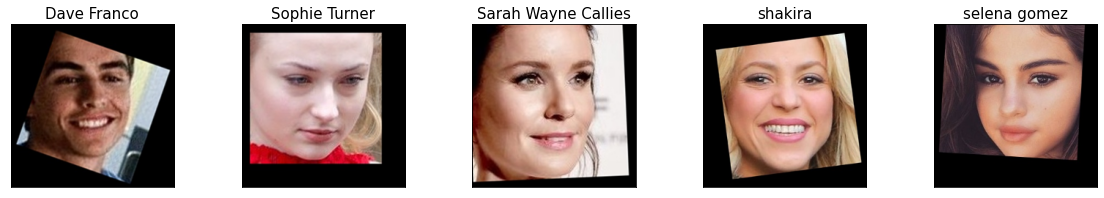

In [16]:
n = 5
fig,ax = plt.subplots(1,n,figsize=(20,3))
for pic in range(n):
  ind = random.randint(0,len(meta_data_df))
  img = read_image(os.path.join(unzip_loc,meta_data_df.iloc[ind]['Filename']),resize=(224,224),cvt_flag=True)
  ax[pic].imshow(img)
  ax[pic].set_title(f"{meta_data_df.iloc[ind]['Celebrity']}",fontsize=15)
  ax[pic].set_xticks([])
  ax[pic].set_yticks([])

plt.show();


# (3) Modelling VGGNet

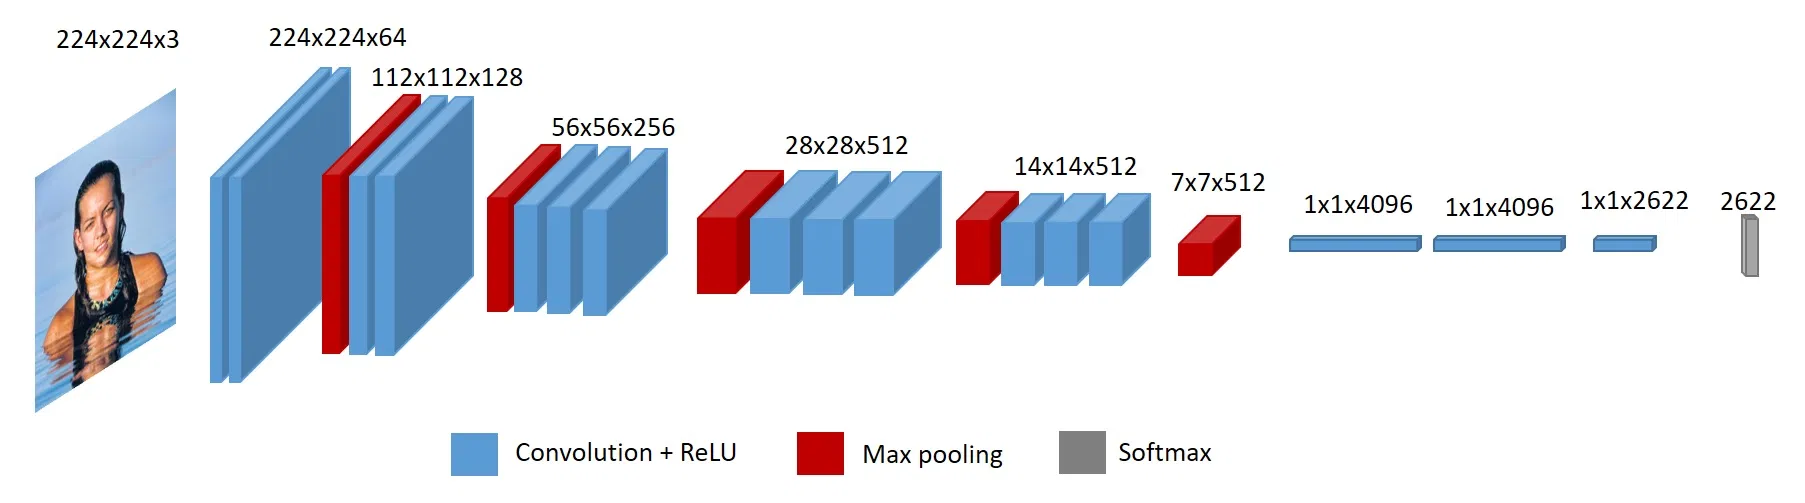

##(3.1) Define a function to call VGGNet with weights provided.

In [17]:
# We will use the above VGG Face architecture up untill the  flatten layer ile not use the softmax output layer

def vgg_face(weights_path=None):	
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape = (224, 224, 3)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides =(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Convolution2D(4096, (7, 7), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    # model.add(Activation('softmax'))

    if weights_path:
        model.load_weights(weights_path)
    return model

## (3.2) Set the path to the VGGNet Weight file.

In [18]:
model_weights_path = os.path.join(project_path,'Part 3 - vgg_face_weights.h5')
model_weights_path

'/content/drive/MyDrive/Colab Notebooks/Project_Object_Detection/OD_Part_3/Part 3 - vgg_face_weights.h5'

## (3.3) Create the model and print the summary

In [19]:
model = vgg_face(model_weights_path)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     7

In [20]:
embed_shape = model.layers[-1].output.shape[1]

display(Markdown(f"#### The shape of the output layer is `{embed_shape}`"))

#### The shape of the output layer is `2622`

#### Observation:
> 1. Model is created with weights as provided.
> 2. The input shape is `(224 X 224 X 3)`.
> 3. The output shape from the last convolution layer is `2622`.

## (3.4) Create helper functions

### (3.4.1) Function to calculate the Euclidena distance gicven two embedding vectors




In [21]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

In [22]:
def get_emb_vec(image_path, model):
  img = read_image(image_path,resize=(224,224),scale=True,cvt_flag=True)
  embed = model.predict(np.expand_dims(img,axis=0))[0]
  # print(embed.shape)
  return embed
  

### (3.4.2) Function to compare two pics and out images with the distance measure

In [23]:
def compare_pics(meta_df,ind_pic_1,ind_pic_2,model,img_base_path):

  pic_1 = os.path.join(img_base_path,meta_df.iloc[ind_pic_1]['Filename'])
  pic_2 = os.path.join(img_base_path,meta_df.iloc[ind_pic_2]['Filename'])  

  name_1 = meta_df.iloc[ind_pic_1]['Celebrity']
  name_2 = meta_df.iloc[ind_pic_2]['Celebrity']

  fig,ax = plt.subplots(1,2,figsize=(8,3))
  img1 = read_image((pic_1),cvt_flag=True,resize=(224,224))
  img2 = read_image((pic_2),cvt_flag=True,resize=(224,224))

  ax[0].imshow(img1);
  ax[0].set_xticks([])
  ax[0].set_yticks([])
  ax[0].set_title(f"{name_1}",fontsize=15)

  ax[1].imshow(img2);
  ax[1].set_xticks([])
  ax[1].set_yticks([])
  ax[1].set_title(f"{name_2}",fontsize=15)

  emb_pic1 = get_emb_vec(pic_1,model)
  emb_pic2 = get_emb_vec(pic_2,model)

  pic_distance = distance(emb_pic1, emb_pic2)
  plt.suptitle(f" Distance: {pic_distance:.2f} ",fontsize=15,y=1.1);

  plt.show();

### (3.4.3) Function to generate embedding from a dataframe consisting of meta data.

In [24]:
  def generate_embeddings(df):
    num_pics = len(df)
    X_embed = []
    y_embed = []

    for idx in tqdm(range(num_pics)):
      pic_path = os.path.join(unzip_loc,df.iloc[idx]['Filename'])
      embed = get_emb_vec(pic_path,model)
      X_embed.append(embed)
      y_embed.append(df.iloc[idx]['Celebrity'])

    X_embed = np.asarray(X_embed)
    y_embed = np.asarray(y_embed)
    return (X_embed,y_embed)


## (3.5) Comparing two images Elon Musk and Henry Cavil and calculating the distance measure between them.

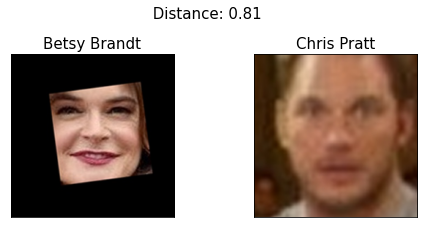

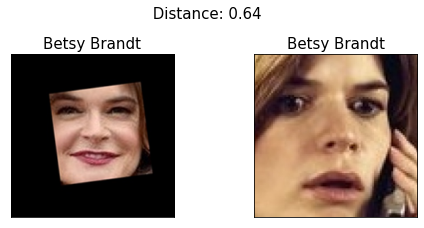

In [39]:
compare_pics(meta_data_df, 170,72, model,unzip_loc)

compare_pics(meta_data_df, 170,150, model,unzip_loc)

#### Observation:
> 1. We have compared two images i.e Betsy Brandt and Chris Pratt.
> 2. Found that the distance between the embedding vector of the same celebrity image is `low i.e 0.64` when compared with another celebrity i.e 0.81
> 3. This means that the model is able to identify between two faces of the same celebrity and different celebrity as well.

## (3.6) Creating embedding for all images in the image set.

In [26]:
X_embed,y_embed = generate_embeddings(meta_data_df)
display(Markdown(f"#### The shape of `X is {X_embed.shape}` and `y is {y_embed.shape}`"))

#### The shape of `X is (10770, 2622)` and `y is (10770,)`

#### Observation:
> 1. Embedding vectors have been correctly created with a shaope of `10770 X 2622` along with their labels .

## (3.7) Using SVM to classify the image 

### (3.7.1) Create the train and test sets from the meta data.

In [27]:
random_state = 2021
test_size = 0.2
test_sample_size = int(len(meta_data_df)*test_size)

In [28]:
test_sample = meta_data_df.sample(test_sample_size,random_state=random_state)
train_sample = pd.concat([meta_data_df,test_sample]).drop_duplicates(keep=False)

display(Markdown(f"#### The shape of Train set is {train_sample.shape} and the shape of Test set is {test_sample.shape}"))

#### The shape of Train set is (8616, 6) and the shape of Test set is (2154, 6)

### (3.7.2) Create embeddings from the train and test samples of image set.

In [29]:
X_train, y_train = generate_embeddings(train_sample)
display(Markdown(f"#### The shape of `X_train is {X_train.shape}` and `y_train is {y_train.shape}`"))
X_test, y_test = generate_embeddings(test_sample)
display(Markdown(f"#### The shape of `X_test is {X_test.shape}` and `y_test is {y_test.shape}`"))

#### The shape of `X_train is (8616, 2622)` and `y_train is (8616,)`

#### The shape of `X_test is (2154, 2622)` and `y_test is (2154,)`

#### Observations:
> 1. Train and Test data has been create with a split of 20% for the test data.

### (3.7.3) Label Encoding the labels.

In [30]:
label_en = LabelEncoder()
display(Markdown(f"#### Label before encoding for the first element in the training set: {y_train[0]}"))
y_train = label_en.fit_transform(y_train)
y_test = label_en.transform(y_test)
display(Markdown(f"#### Label after encoding for the first element in the training set : {y_train[0]}"))

#### Label before encoding for the first element in the training set: Chris Pratt

#### Label after encoding for the first element in the training set : 14

### (3.7.4) Principal Component Analysis.

In [31]:
pca = PCA(whiten=True, random_state=random_state)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=2021,
    svd_solver='auto', tol=0.0, whiten=True)

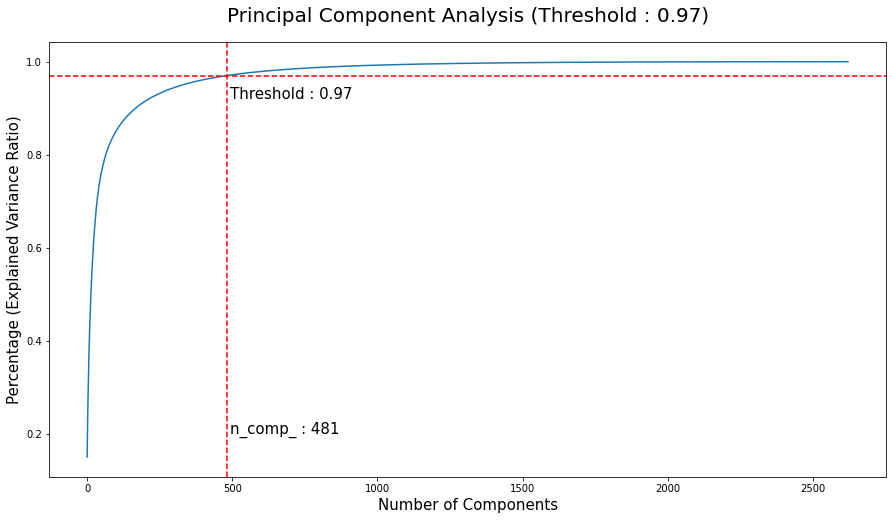

In [32]:
threshold = 0.97
temp_ = 0.0
n_comp_ = 0

for var_ in pca.explained_variance_ratio_:
  if temp_ <= threshold:
    temp_ += var_
    n_comp_ += 1
  else:
    break  

fig, ax = plt.subplots(figsize=(15,8))
sns.lineplot(x=range(len(pca.explained_variance_ratio_)), y=np.cumsum(pca.explained_variance_ratio_))
plt.axvline(x=n_comp_, color='r',linestyle='--')
plt.axhline(y=threshold, color='r',linestyle='--')
plt.annotate(f"Threshold : {threshold}",xy=(n_comp_+10,threshold-0.05),fontsize=15)
plt.annotate(f"n_comp_ : {n_comp_}",xy=(n_comp_+10,0.2),fontsize=15)
plt.xlabel("Number of Components",fontsize=15)
plt.ylabel("Percentage (Explained Variance Ratio)",fontsize=15)
plt.title(f"Principal Component Analysis (Threshold : {threshold})",fontsize=20,pad=20)
plt.show()



#### Observations:
> 1. PCA suggests that atleast 481 components are required to acheive a variance of 97% in the image data.
> 2. This is a significant reduction from a size of 2622 from the convolution network.

#### (3.7.4.1) Transform the train and test sets from 2622 features to 481 principal components.

In [33]:
pca = PCA(n_components = n_comp_, random_state = random_state, svd_solver = 'full', whiten = True)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
display(X_train_pca.shape, X_test_pca.shape)


(8616, 481)

(2154, 481)

#### Observations:
> 1. Principal components are correctly created.

### (3.7.5) Create and SVM model and find the best params.

In [34]:
%%time

params_grid = [{'kernel': ['rbf','linear'], 
                'gamma': [1e-2, 1e-3, 1e-4], 
                'C': [1, 10, 100, 1000], 
                'class_weight': ['balanced', None]}]

clf = GridSearchCV(SVC(random_state = random_state), params_grid, cv = 3, scoring = 'accuracy', verbose = 50, n_jobs = -1)
clf.fit(X_train_pca, y_train)

print('Best estimator found by grid search:')
print(clf.best_estimator_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3

In [35]:
display(Markdown(f'#### Best params for the SVC model are : `{clf.best_params_}`'))

display(Markdown(f'#### SVC accuracy for train set: `{clf.score(X_train_pca, y_train):.3f}`'))

#### Best params for the SVC model are : `{'C': 10, 'class_weight': 'balanced', 'gamma': 0.0001, 'kernel': 'rbf'}`

#### SVC accuracy for train set: `0.997`

In [36]:
# svc_pca = clf.best_estimator_
# svc_pca.fit(X_train_pca,y_train)
# display(Markdown(f'#### SVC accuracy for train set: `{svc_pca.score(X_train_pca, y_train):.3f}`'))

In [37]:
y_pred = clf.predict(X_test_pca)
display(Markdown(f'#### SVC accuracy for test set: {accuracy_score(y_test, y_pred):.3f}'))

#### SVC accuracy for test set: 0.969

#### Observation:
> 1. On the training set, we have acheived an accuracy score of `99.7 %`.
> 2. On the testinhg set, we have acheieved an accuracy score of `95.6%`.
> 3. Best parameters of the model is shown above.

### (3.7.6) Plot the images along with actual and predicted labels.

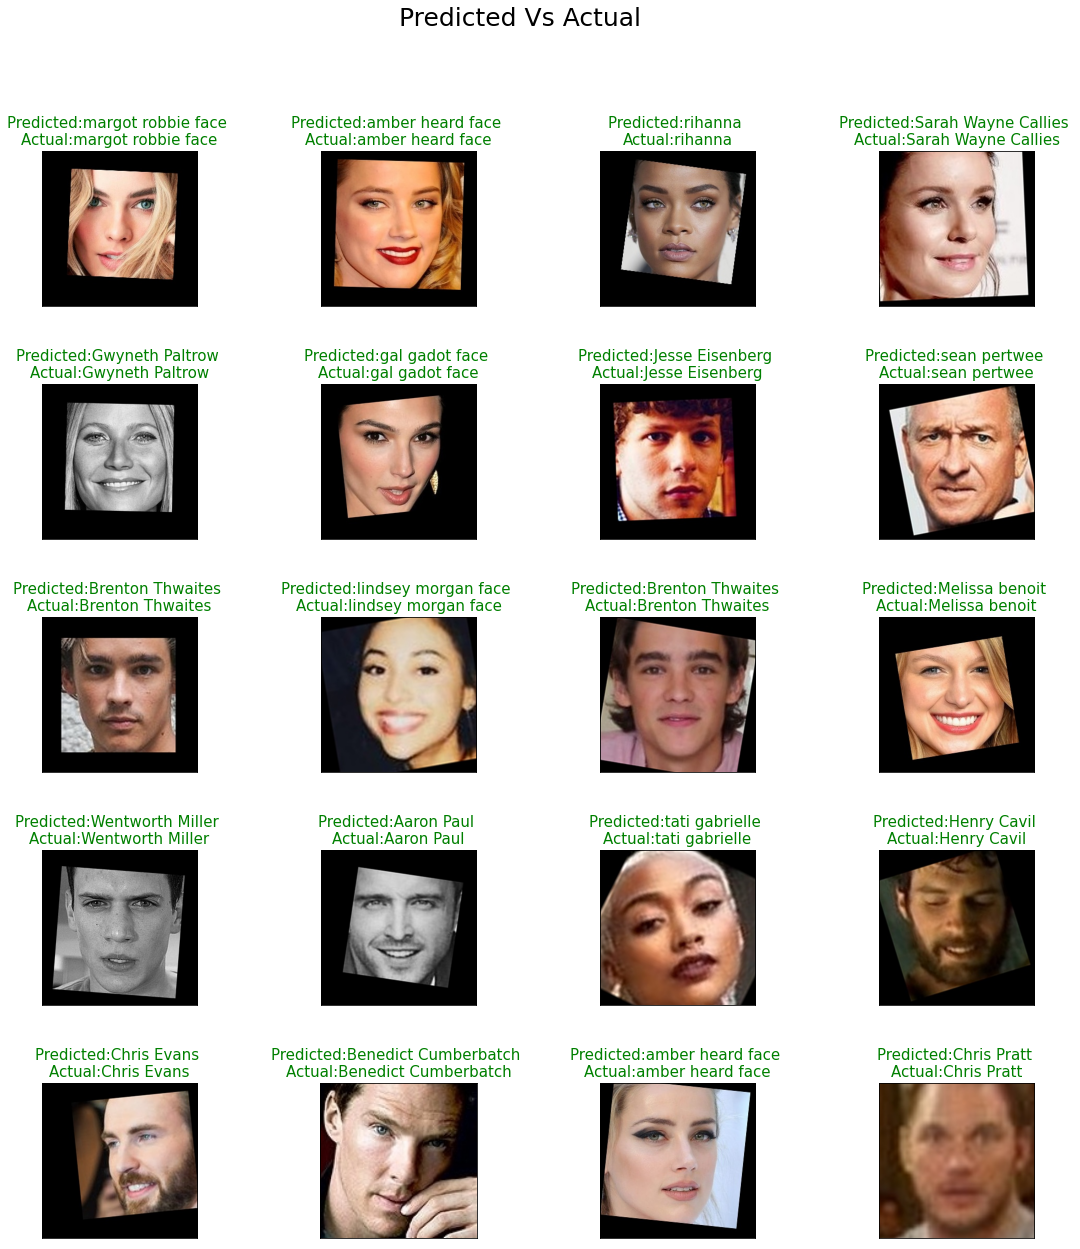

In [38]:
n_sample = 20
plt.figure(figsize = (20, 20))
gs1 = gridspec.GridSpec(5, 4)
gs1.update(wspace = 0, hspace = 0.5) 
i=0

test_embed = generate_embeddings(test_sample.reset_index().iloc[:n_sample])
clear_output(wait=True)

plt.suptitle("Predicted Vs Actual",fontsize=25)
for embeds,filename in zip(test_embed[0], test_sample.reset_index().iloc[:n_sample]['Filename'].values ):
  actual_label = filename.split('/')[0].split('_')[1]
  pred = clf.predict(pca.transform(embeds.reshape(1,-1)))
  predicted_label = label_en.classes_[pred][0]

  ax1 = plt.subplot(gs1[i])
  plt.axis('on')
  ax1.set_xticks([])
  ax1.set_yticks([])
  ax1.set_aspect('equal')
  plt.imshow(read_image(os.path.join(unzip_loc,filename),cvt_flag=True))
  plt.title(f"Predicted:{predicted_label} \nActual:{actual_label}",color = 'green' if actual_label == predicted_label else 'red',fontsize=15)

  i+=1


#### Observation:
> 1. As we see, we have correctly predicted names of all celebrities from their facial images.
> 2. SVM has performed well on the test set as well.


# (4) Conclusion

> 1.Task here was to recognize (align) faces from a dataset containing 10k+ images for 100 celebrities using a pre-trained model on Face Recognition.
> 2. VGGNet with pre-trained weights was used to generate embeddings for each images in the dataset.
> 3. Distance between two pairs of images were also calculated and plotted.
> 4. PCA was used for dimension reduction after standardizing the features.
> 5. With an cumulative explained variance of 97%, 480 PCA components were used.
> 6. Using SVC we predicted the labels for test dataset with an accuracy of  99.7% on training and almost 96% on the test set.
> 7. Also compared predicted and actual labels for a given sample image as well as for 20 images from test dataset. Here all images were correctly classified.
